
Use the Lehman rep package for fast fourier transforms to
solve the self-consistent equations directly at very low temperatures

A large-N Schwinger boson solver based on a forward fixed-point iteration method.

The self-energy of bosons and holons are given by,

   Σ_B(τ) = - γ G_c(τ) * G_h(τ),

   Σ_h(τ) = - G_c(β - τ) * G_b(τ),
   
where the boson and holon Green's function are given by the Dyson equation,

   G_B(iωₙ) = 1/(iνₙ - λ - Σ_B(iνₙ))

   G_h(iωₙ) = 1/(-1/J_K - Σ_h(iνₙ))

Furthermore, we need to enforce the Lagrange multiplier constraint, such that the
boson occupation number is maintained at q= 2S/N (a pre-defined and constant scalar).
This leads to 

n_b(λ) = G_b (τ = 0-) = q

Therefore, one needs to find the correct λ to satisfy this.

We solve the Dyson equation self-consistently by a weighted fixed point iteration, 
with weight `mix` assigned to the new iterate and weight `1-mix` assigned to the previous iterate. 
mix can be rather big for this non-critical system.
 
The self-energy is evaluated in the imaginary time domain, 
and the Dyson equation is solved in the Matsubara frequency domain.

Note that an alternate notebook can be written through the GreenFunc.jl package.


Important links: 
https://numericaleft.github.io/Lehmann.jl/dev/lib/spectral/
https://arxiv.org/pdf/2107.13094.pdf
https://en.wikipedia.org/wiki/Matsubara_frequency


In [61]:
using Lehmann
using Printf
using Roots

diff(a, b) = maximum(abs.(a - b)) # return the maximum deviation between a and b
diff_modulated(a, b) = sum(abs.(a - b)) /sum(abs.(b)) # return the maximum deviation between a and b


# Initialize DLR grid

rtol = 1e-8
β = 100.0  #inverse temperature
Euv = 100 #UV cutoff
df = DLRGrid(Euv = Euv, β = β, isFermi = true, rtol = rtol, symmetry = :none) #fermionic DLR grid
db = DLRGrid(Euv = Euv, β = β, isFermi = false, rtol = rtol, symmetry = :none) #bosonic DLR grid


G_B = zeros(ComplexF64, length(db))
G_h = zeros(ComplexF64, length(df))
G_B_new = zeros(ComplexF64, length(db))
G_h_new = zeros(ComplexF64, length(df))
Sigma_B = zeros(ComplexF64, length(db)) 
Sigma_h = zeros(ComplexF64, length(df))
#some small broadening at the beginning is necessary
#Sigma_B = 1im*eta*ones(ComplexF64, length(db)) 
#Sigma_h = 1im*eta*ones(ComplexF64, length(df))

D = 20  #the half electronic bandwidth, needs to be smaller than Euv
ρ = 1/(2*D)
#below is the conduction electron bandwidth - this could be changed to be more "realistic"
G_c_matfreq = - ρ .* log.( (D .- df.ωn * 1im) ./ (- D .- df.ωn * 1im))
G_c = matfreq2tau(df, G_c_matfreq)

q0 = 0.5 # q0 = 2S/N
γ = q0  # γ ≠ q0 means a under or over screened Kondo model 
λ = (1/β) * log(1/q0 +1) #initial λ for the loop
eta = 0.001*λ
β_K = 50  #Kondo temperature, used to define J_K, needs to be larger than initial β
J_K = 1 / ρ / log(D * β_K) #alternatively, J_K could be defined by itself

#initialize G_B and G_h with their broadening factors.
#G_B = G_B .+ 1 ./(db.ωn * 1im .- λ + )
#G_h = G_h .- J_K #this is the initial value
#Sigma_B_matfreq = tau2matfreq(db, Sigma_B)
#Sigma_h_matfreq = tau2matfreq(df, Sigma_h)
#G_B_new = 1 ./(db.ωn * 1im .- λ .- 1im*eta*ones(ComplexF64, length(db)) ) #in omega freq
G_B_new = G_B_new + 1 ./(db.ωn * 1im .- λ) #in omega freq
G_h_new = G_h_new .+ 1 ./((-1.0 ./J_K )) #in omega freq
#in τ form
G_B = G_B + matfreq2tau(db, G_B_new)
G_h = G_h + matfreq2tau(df, G_h_new)

#change initial G_B and G_h to tau format

function nB_from_Gb_omega(Gfunc, dfreq, x)
   #feed in the freq. valued green's function
   new_Gfunc = 1.0 ./((1.0 ./Gfunc) .- x)
   all_G_tau_dlr = matfreq2tau(dfreq, new_Gfunc) #last element is G(τ = 0-)
   return -real(all_G_tau_dlr[end])
end

#plot sanity check
#using Plots
#plot(df.τ, real.(G_c))

G_B_omega = tau2matfreq(db, G_B)
f(x) = abs(q0 - nB_from_Gb_omega(G_B_omega, db, x)) #define the function for which the root needs to be found
xval = find_zero(f, 0, order=1) #find the root. x is such that λ_tot = λ + x
println("Initial Lagrange multiplier times β: $((λ + xval)*β), x=$xval and n_b - q = $(f(xval))")
#G_B_new = 1 ./(db.ωn * 1im .- λ .- xval .- 1im*eta*ones(ComplexF64, length(db)) ) #in omega freq
G_B_new = 1 ./(db.ωn * 1im .- λ .- xval) #in omega freq
G_B = matfreq2tau(db, G_B_new);


Initial Lagrange multiplier times β: 1.0986079130216133, x=-4.375646496319935e-8 and n_b - q = 2.429667578240924e-12


In [62]:
#iteration process
#needs to be put into a function
mix = 0.01
maxiter = 1000
numprint = 20
sumrule = nothing
verbose = true
#tol = -maximum([-df.rtol * 10, -db.rtol * 10])
tol = 1e-3

#conduction electron G does not change
tau_c = df.τ # DLR imaginary time nodes
tau_c_rev = df.β .- tau_c # Reversed imaginary time nodes
G_c_rev = tau2tau(df, G_c, tau_c_rev) # G_c at beta - tau_k

cont = 1
iter = 1
while cont == 1
   #old green's functions
   G_B_old = G_B
   G_h_old = G_h
   #self energy equations in τ
   Sigma_B = - γ .* G_h .* G_c
   Sigma_h = G_B .* G_c_rev
   #their ωn counterparts
   Sigma_B_matfreq = tau2matfreq(db, Sigma_B)
   Sigma_h_matfreq = tau2matfreq(df, Sigma_h)

   #define new G_B and G_h in ωn using the self-energy
   #1)
   #solve the Lagrange multiplier constraint with new G_B 
   G_B_omega = 1 ./(db.ωn * 1im .- λ.- Sigma_B_matfreq)
   f(x) = abs(q0 - nB_from_Gb_omega(G_B_omega, db, x)) #define the function for which the root needs to be found
   xval = find_zero(f, xval, order=1, atol=1e-3) #find the root. x is such that λ_tot = λ + x
   #2) create the new GB and Gh
   G_B_new = 1 ./(db.ωn * 1im .- λ .- xval .- Sigma_B_matfreq)
   G_h_new = 1 ./((- 1 ./J_K ) .- Sigma_h_matfreq)
   #convert them to τ space
   G_B_new_tau = matfreq2tau(db, G_B_new)
   G_h_new_tau = matfreq2tau(df, G_h_new)

   #mix old and new solutions together 
   G_B = mix * G_B_new_tau + (1 - mix) * G_B_old # Linear mixing
   G_h = mix * G_h_new_tau + (1 - mix) * G_h_old # Linear mixing

   #distance between old and new solution.
   dist_GB = diff_modulated(G_B, G_B_old)/mix
   dist_Gh = diff_modulated(G_B, G_B_old)/mix

   if sqrt(dist_GB^2 + dist_Gh^2) < tol || iter > maxiter
      cont = 0
   end

   if verbose && iter % (maxiter / numprint) == 0
      #println("round $iter: change B $(diff(G_B_old, G_B)) change χ $(diff(G_h_old, G_h))")
      println("round $iter: change B $dist_GB change χ $dist_Gh")
   end

   if verbose && iter % (maxiter / numprint) == 0
      println("Lagrange multiplier times β: $((λ + xval)*β) and n_b - q = $(f(xval))")
      println(" ")
   end

   iter += 1

   flush(stdout)

end

print("done in $iter steps")

round 50: change B 0.46845402805862124 change χ 0.46845402805862124
Lagrange multiplier times β: 17.007992138285964 and n_b - q = 1.1528593257814634e-6
 


round 100: change B 0.648361234529044 change χ 0.648361234529044
Lagrange multiplier times β: 44.5302590753099 and n_b - q = 0.000856815590196236
 


round 150: change B 0.591926326460522 change χ 0.591926326460522
Lagrange multiplier times β: 49.41739669798313 and n_b - q = 2.3156156093717684e-6
 


round 200: change B 0.41998834511923044 change χ 0.41998834511923044
Lagrange multiplier times β: 45.52792647648117 and n_b - q = 8.858005569012395e-5
 


round 250: change B 0.19747660868693304 change χ 0.19747660868693304
Lagrange multiplier times β: 39.24894181078253 and n_b - q = 0.00014578237351881018
 


round 300: change B 0.08824429623197538 change χ 0.08824429623197538
Lagrange multiplier times β: 33.97669590498577 and n_b - q = 4.4958086887647575e-5
 


round 350: change B 0.13069377674737626 change χ 0.13069377674737626
Lagrange multiplier times β: 31.244343134451775 and n_b - q = 6.48391374069579e-6
 


round 400: change B 0.12123371797214393 change χ 0.12123371797214393
Lagrange multiplier times β: 30.95926833984458 and n_b - q = 2.487935415795839e-6
 


round 450: change B 0.09226657654759758 change χ 0.09226657654759758
Lagrange multiplier times β: 32.20862720691529 and n_b - q = 2.683206264975091e-5
 


round 500: change B 0.06717417621229994 change χ 0.06717417621229994
Lagrange multiplier times β: 34.07159521611509 and n_b - q = 6.342596167874248e-5
 


round 550: change B 0.052355648003181834 change χ 0.052355648003181834
Lagrange multiplier times β: 35.97267472534196 and n_b - q = 2.9625099781660502e-5
 


round 600: change B 0.04598275412661205 change χ 0.04598275412661205
Lagrange multiplier times β: 37.677779432864824 and n_b - q = 2.4257193143695233e-5
 


round 650: change B 0.04473179808308728 change χ 0.04473179808308728
Lagrange multiplier times β: 39.16461327544049 and n_b - q = 1.1530734955078614e-5
 


round 700: change B 0.046086843253420426 change χ 0.046086843253420426
Lagrange multiplier times β: 40.50102335723938 and n_b - q = 2.3140945045185823e-5
 


round 750: change B 0.048600515065299256 change χ 0.048600515065299256
Lagrange multiplier times β: 41.771606959968395 and n_b - q = 1.3973463540928321e-5
 


round 800: change B 0.05169490292559778 change χ 0.05169490292559778
Lagrange multiplier times β: 43.046392037709715 and n_b - q = 3.517347969339557e-5
 


round 850: change B 0.05536360556803081 change χ 0.05536360556803081
Lagrange multiplier times β: 44.37578741255047 and n_b - q = 6.902955775767161e-6
 


round 900: change B 0.05992111125859438 change χ 0.05992111125859438
Lagrange multiplier times β: 45.79729658938872 and n_b - q = 7.716697165538466e-6
 


round 950: change B 0.06587235796520363 change χ 0.06587235796520363
Lagrange multiplier times β: 47.345474601102374 and n_b - q = 2.5682950199668042e-5
 


round 1000: change B 0.07392091892552358 change χ 0.07392091892552358
Lagrange multiplier times β: 49.06216212271237 and n_b - q = 7.185001799303592e-6
 


done in 1002 steps

In [64]:
#phase shift calculation - does not seem good
imag(log(sum(G_h)/β))/π

0.4266237343161903

In [65]:
#test if the solutions work

#first version of Self energies
G_B_omega = tau2matfreq(db, G_B)
Sigma_B_one = matfreq2tau(db, - ((1.0 ./ G_B_omega) .- db.ωn * 1im .+ λ .+ xval))
G_h_omega = tau2matfreq(df, G_h)
Sigma_h_one = matfreq2tau(df, - ((1.0 ./ G_h_omega) .- (- 1 ./J_K )))

#conduction electron G does not change
Sigma_B_two = - γ .* G_h .* G_c
Sigma_h_two = G_B .* G_c_rev


println("check: Σ(1)_B - Σ(2)_B $(diff_modulated(Sigma_B_two, Sigma_B_one)) Σ(1)_χ - Σ(2)_χ $(diff_modulated(Sigma_h_two, Sigma_h_one))")

check: Σ(1)_B - Σ(2)_B 0.02273371693519352 Σ(1)_χ - Σ(2)_χ 0.06657053287482526


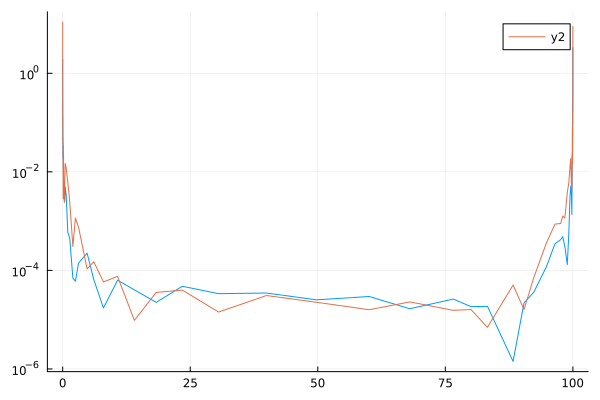

In [66]:
using Plots
plot(db.τ, abs.(imag(Sigma_B_one) - imag(Sigma_B_two)), yscale=:log10, label="")
plot!(db.τ, abs.(real(Sigma_B_one) - real(Sigma_B_two)), yscale=:log10)